In [1]:
from espuma import Case_Directory, Boundary_Probe
from espuma_utils import get_profile_over_depth, get_timestep_integrated

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import cmasher as cmr  #noqa
import colorcet as cc  #noqa
import numpy as np
from scipy.integrate import cumulative_trapezoid
from matplotlib import patheffects

import multiprocessing as mp
import pickle 
from pathlib import Path

plt.style.use('./matplotlib_style/edwin.mplstyle')

try:
    NOTEBOOK_NAME = __file__
except NameError:
    NOTEBOOK_NAME = __vsc_ipynb_file__ #noqa: F821 #type: ignore


In [2]:
# cases_folder = Path("CASES_drying_periods")
cases_folder = Path("CASES_evaluate_dry_lengths")
cases_list = sorted(
    [f for f in cases_folder.iterdir() if f.is_dir() and 'flood' in f.name], 
    key= lambda x: float(x.name.rpartition('_')[-1])
)


In [3]:
def calculate_total_flux(case: Path):
    
    of_case = Case_Directory(case)
    prb = Boundary_Probe(of_case, of_case.system.boundaryProbes)
    xarr = prb.array_data

    t_secs = xarr.time.to_numpy()
    # u_bottom = xarr.isel(probes=0).Uz.to_numpy()
    u_top = xarr.isel(probes=1).Uz.to_numpy()
    u_top_cum = cumulative_trapezoid(y = np.abs(u_top), x = t_secs)

    return (t_secs, u_top, u_top_cum)

In [4]:
Path(cases_folder / "probed_velocities").mkdir(exist_ok=True)
pickle_file = Path(cases_folder / "probed_velocities" / "velocities.pkl")

if not pickle_file.exists():
    
    with mp.Pool() as pool:
        u_all_cases = pool.map(calculate_total_flux, cases_list)

    with open(pickle_file, 'wb') as f:
        pickle.dump({'cases_list': cases_list, 'u_all_cases': u_all_cases}, f)

else:
    with open(pickle_file, 'rb') as f:
        datapkl = pickle.load(f)
        cases_list = datapkl['cases_list']
        u_all_cases = datapkl['u_all_cases']
    del datapkl


In [5]:
final_flow = [u[-1] for _, _, u in u_all_cases]

In [6]:
for s,v in zip(cases_list, final_flow):
    flood = int(s.name.partition('__')[0].partition('_')[-1])
    dry = int(s.name.partition('__')[-1].partition('_')[-1])

    print(f"Flood {flood:>5}: Dry {dry:>4} \t = {v:.4f}")


Flood 115200: Dry    0 	 = 1.8185
Flood   150: Dry  675 	 = 1.3942
Flood   300: Dry 1350 	 = 1.7376
Flood   450: Dry 2025 	 = 1.8114
Flood   600: Dry 2700 	 = 1.8581
Flood   750: Dry 3375 	 = 1.9074
Flood   900: Dry 4050 	 = 2.0439
Flood  1050: Dry 4725 	 = 2.0423
Flood  1200: Dry 5400 	 = 2.0982
Flood  1350: Dry 6075 	 = 2.1216
Flood  1500: Dry 6750 	 = 2.1486
Flood  1650: Dry 7425 	 = 2.1856
Flood  1800: Dry 8100 	 = 2.2029


In [7]:
cases_names = [f.name for f in cases_list]

wet_times = [int(s.partition('__')[0].partition('_')[-1]) for s in cases_names]
dry_times = [int(s.rpartition('__')[-1].partition('_')[-1]) for s in cases_names]
ratios_dry_over_wet_time = [d/w for (w, d) in zip(wet_times, dry_times)]

bouwer_2012_hydraulic_load = [v/80 for v in final_flow]

In [8]:
cmap = plt.get_cmap('cet_kb', len(cases_names))
colors = cmap(np.linspace(0, 1, len(cases_names)))


In [9]:
ratios_dry_over_wet_time

[0.0, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5]

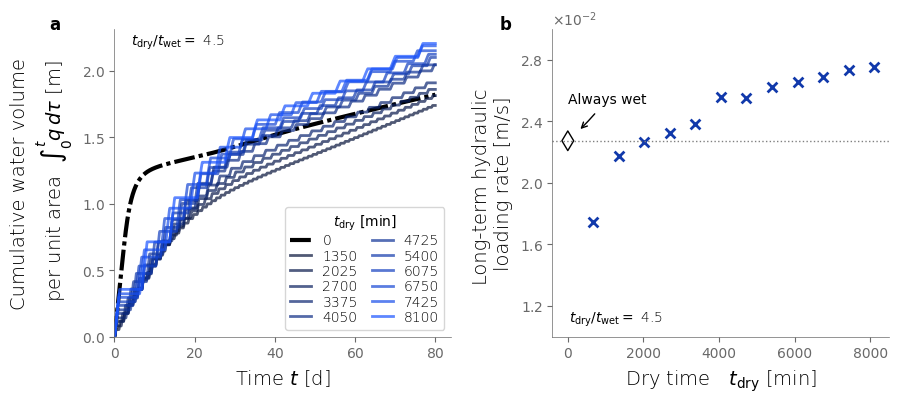

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,4), gridspec_kw=dict(wspace=0.3))

ax = axs[0]
for s, u, color in zip(cases_names, u_all_cases, colors):
    
    t_secs, u_top, u_top_cum = u
    flood = int(s.partition('__')[0].partition('_')[-1])
    dry = int(s.partition('__')[-1].partition('_')[-1])
    t_days = t_secs / 86_400
    
    if dry != 675:
        if dry == 0:
            lw, ls, alpha, zorder = 3, (0, (5, 1, 1, 1)), 1, 1
        else:
            lw, ls, alpha, zorder = 2, 'solid', 0.7, 2
        
        ax.plot(
            t_days[1:], u_top_cum, label =str(dry), 
            lw=lw, c=color, zorder=zorder, alpha=alpha, ls=ls)
    
ax.ticklabel_format(useMathText=True)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Time $t$ [d]")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_ylabel("Cumulative water volume\n per unit area\t"  R"$\int_{0}^{t}{q\,d\tau}$ [m]")
# ax.set_ylabel("Water volume per unit area\n"  R"$\int{q\,dt}$ [m]")
ax.legend(title=R"$t_{\mathsf{dry}}$ [min]",
    loc='lower right', bbox_to_anchor=(1.0, 0), 
    prop=dict(size=10, weight=100),
    labelspacing=0.1, handlelength=1.5,
    columnspacing = 1,  ncols=2, 
    )
ax.text(
    0.05, 0.95, R"${t_{\mathsf{dry}}}/{t_{\mathsf{wet}}} = $ 4.5",
    ha='left', transform=ax.transAxes, weight=100
)

ax = axs[1]

ax.scatter(dry_times[1:], bouwer_2012_hydraulic_load[1:], marker='x', s=50, color=colors[-5])

y = bouwer_2012_hydraulic_load[0]
pt = ax.scatter(dry_times[0:1], [y], marker='d', s=100, facecolor="None", edgecolor='k')
ax.axhline(y, lw=1, c='grey', ls='dotted')

# for t, y in zip(
#     dry_times, bouwer_2012_hydraulic_load
#     ):

#     marker = "x" if t > 0 else "d"
#     facecolor = colors[1] if t > 0 else "None"
#     size = 50 if t > 0 else 100
#     pt = ax.scatter([t], [y],  color=colors[1], s=size, label=label, marker=marker, facecolor=facecolor)

#     if t == 0:
ax.annotate(
    "Always wet", (0, y), (0, 1.1*y),
    ha='left', va='bottom',
    arrowprops=dict(
        arrowstyle='->', connectionstyle="arc3,rad=-0.05",
        color="k", shrinkA=5, shrinkB=5, patchB=pt,
    )
)

ax.ticklabel_format(axis='y', useMathText=True, scilimits=(0,0))
ax.yaxis.set_major_locator(MaxNLocator(5))

ax.set_xlabel(R"Dry time   $t_{\mathsf{dry}}$ [min]")
# ax.set_xlim(left=-0.9)
ax.set_ylim(0.01, 0.03)
ax.set_ylabel("Long-term hydraulic \nloading rate [m/s]")

ax.text(
    0.05, 0.05, R"${t_{\mathsf{dry}}}/{t_{\mathsf{wet}}} = $ 4.5", 
    ha='left', transform=ax.transAxes, weight=100
)

fig.text(0.06 ,0.88, "a", size=12, weight=700)
fig.text(0.51 ,0.88, "b", size=12, weight=700)

plt.savefig(
    f"plots/{NOTEBOOK_NAME.rpartition('/')[-1].removesuffix('.ipynb')}(treated_volume).pdf", 
    format="pdf", bbox_inches='tight', pad_inches=0.05
)

plt.show()

In [11]:
TIME_TARGET = 60  # <- Get day 50
profiles = [get_profile_over_depth(Case_Directory(d), t_target_days=TIME_TARGET) for d in cases_list]
integrateds = [get_timestep_integrated(Case_Directory(d), t_target_days=TIME_TARGET) for d in cases_list]

cross_area_column = (
    float(Case_Directory(cases_list[0]).system.blockMeshDict["diameter"]) ** 2
)

In [12]:
biomass_colors = {
    'active': "#ff3146", 
    'inactive':"#4f4b7e",
    'labile': "#5470b8",
    'recalcitrant': "#4f4b7e"}

stack_colors = [c for k,c in biomass_colors.items() if k != 'inactive']

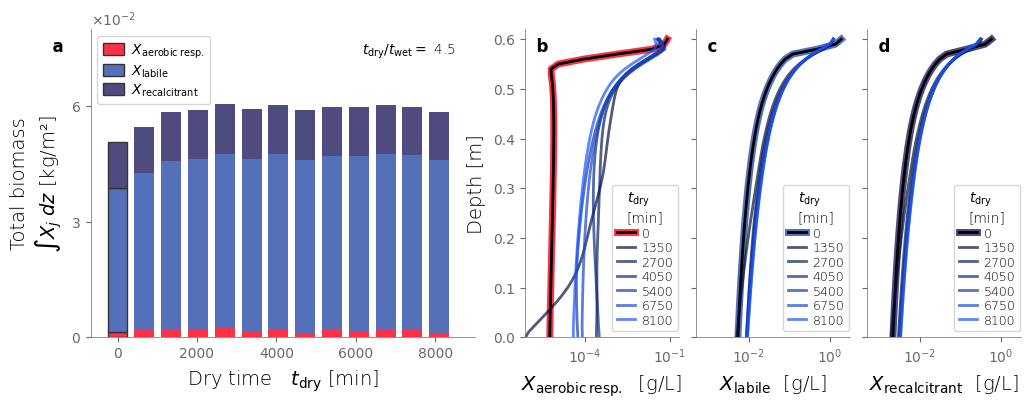

In [13]:
fig_profiles, axs = plt.subplots(
    1, 5, figsize=[12, 4], sharey=False, width_ratios=[2.5,0.1,1,1,1],
    gridspec_kw=dict(wspace=0.1)
)

bax = axs[0]
hax = axs[1]
axs = axs[2:]

for profile, t, color in zip(profiles[::2], dry_times[::2], colors[::2]):
    
    alpha = 1 if t == 0 else 0.7

    for i, (ax,field) in enumerate(zip(axs[:3], ["XAR", "EPS", "XI"])):
        label = f"{t}"
        pe = [
            patheffects.withStroke(linewidth=5, foreground=stack_colors[i]), 
            # patheffects.withStroke(linewidth=3, foreground='w')
        ] if t == 0 else None

        ax.plot(profile[field], profile["Distance"], label=label, c=color, alpha=alpha, path_effects=pe, lw=2)

axs[0].set_xlabel(R"$X_{\mathsf{aerobic\,resp.}}$  [g/L]")
axs[1].set_xlabel(R"$X_{\mathsf{labile}}$  [g/L]")
axs[2].set_xlabel(R"$X_{\mathsf{recalcitrant}}$  [g/L]")

axs[0].set_ylabel("Depth [m]")

axs[0].set_xlim(8e-7, 2e-1)
axs[1].set_xlim(5e-4, 3e0)
axs[2].set_xlim(5e-4, 3e0)

plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[2].get_yticklabels(), visible=False)

for ax in axs:
    ax.legend(
        title="$t_{\mathsf{dry}}$" "\n[min]",
        loc="lower right", bbox_to_anchor=(1.04, 0),
        prop=dict(weight=100, size=9),
        title_fontproperties={'weight':100},
        labelspacing=0.2, handlelength=1.5,
        handletextpad=0.5, handleheight=1
    )

for ax,t in zip(axs[:3],[*"bcd"]):
    ax.set_xscale("log")
    ax.set_ylim(bottom=0, top=0.62)
    ax.set_title(f"  {t}", loc='left', y=0.9, weight=700)

#### Bar plot ###########
ax = bax
for t, integrated, c in zip(dry_times, integrateds, colors):
    marker = "o" if t > 0 else "d"
    ec = "#333333" if t ==0 else None
    width = 500

    xar = integrated["XAR"][0] / cross_area_column
    xeps = integrated["EPS"][0] / cross_area_column
    xrec = integrated["XI"][0] / cross_area_column

    ax.bar(t, xar, width=width, color=biomass_colors['active'], ec=ec)
    ax.bar(t, xeps, bottom = xar, width=width, color=biomass_colors['labile'], ec=ec)
    ax.bar(t, xrec, bottom = xar + xeps, width=width, color=biomass_colors['recalcitrant'], ec=ec)


ax.ticklabel_format(axis="y", useMathText=True, scilimits=(0, 0))
ax.yaxis.set_major_locator(MaxNLocator(3))

ax.set_xlabel(R"Dry time   $t_{\mathsf{dry}}$ [min]")
ax.set_ylim(bottom=0, top=8e-2)
ax.set_xlim(right=9000)

ax.set_ylabel("Total biomass\n" + R"$\int{X_j} \; dz$ [kg/m²]")

ax.legend(
    [R"$X_{\mathsf{aerobic\;resp.}}$", R"$X_{\mathsf{labile}}$", R"$X_{\mathsf{recalcitrant}}$"],
    loc="upper left", ncols=1,
    prop=dict(weight=100, size=10),
    labelspacing=0.2, handlelength=1.5,
    handletextpad=0.5, handleheight=1
)

ax.text(
    0.95, 0.92, R"${t_{\mathsf{dry}}}/{t_{\mathsf{wet}}} = $ 4.5", 
    ha='right', transform=ax.transAxes, weight=100
)

ax.set_title("  a", x=-0.1, y=0.9, weight=700)

## White space axes
hax.axis('off')

plt.savefig(
    f"plots/{NOTEBOOK_NAME.rpartition('/')[-1].removesuffix('.ipynb')}(biomass_profiles).pdf", 
    format="pdf", bbox_inches='tight', pad_inches=0.05
)

plt.show()

LinregressResult(slope=6.644843770155988e-07, intercept=0.05580752538184255, rvalue=0.6272163010531732, pvalue=0.021757820600879232, stderr=2.4878385596750876e-07, intercept_stderr=0.0011874380733294487)
reg.pvalue < 0.01 = False


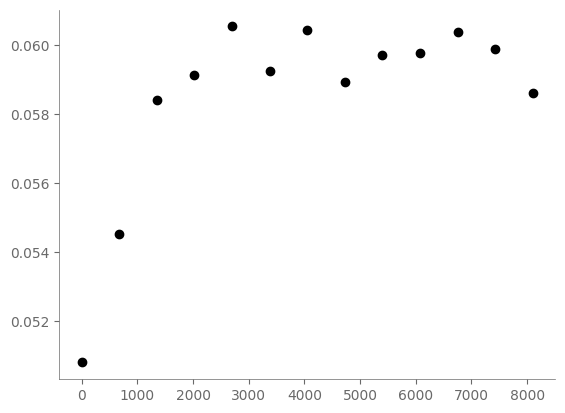

In [47]:
from scipy.stats import linregress

x = dry_times
y = [
    integrated["XAR"][0] 
    + integrated["EPS"][0]
    + integrated["XI"][0]
    for integrated in integrateds]

y = [yi/cross_area_column for yi in y]

plt.scatter(x,y)
reg = linregress(x,y)

print(reg)
print(f"{reg.pvalue < 0.01 = }")